In [1]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [2]:
dataset_path = "/Users/anushreem/Downloads/DATASET"

In [3]:
import os
print(os.listdir(dataset_path))

['.DS_Store', 'TEST', 'TRAIN']


In [4]:
train_dir = os.path.join(dataset_path, 'TRAIN')
test_dir = os.path.join(dataset_path, 'TEST')

In [5]:
!conda install matplotlib -y

Channels:
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [6]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the base MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build the full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 output classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2025-07-26 19:15:54.140415: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-26 19:15:54.140495: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-26 19:15:54.140516: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753537554.140554  245950 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753537554.140605  245950 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Unfreeze top layers for fine-tuning
base_model.trainable = True

# Freeze all layers except the top 50
for layer in base_model.layers[:-20]:
    layer.trainable = False


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.


In [10]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install Pillow

In [12]:
from PIL import ImageFile

from PIL import Image

def convert_image(path):
    img = Image.open(path)
    if img.mode == 'P' or img.mode == 'LA':
        img = img.convert("RGBA")
    return img
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='models/words_model/words_model_final.keras',  # use `.keras` extension
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [14]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
import sys
!{sys.executable} -m pip install -U scikit-learn


In [16]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

/opt/anaconda3/envs/tf-mac/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-07-26 19:16:15.710247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 5/28 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.2275 - loss: 2.1737

/opt/anaconda3/envs/tf-mac/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 375ms/step - accuracy: 0.2382 - loss: 2.1924 - val_accuracy: 0.1814 - val_loss: 2.0257 - learning_rate: 1.0000e-05
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.2393 - loss: 2.2094 - val_accuracy: 0.2930 - val_loss: 1.7875 - learning_rate: 1.0000e-05
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.3419 - loss: 1.8434 - val_accuracy: 0.2884 - val_loss: 1.7021 - learning_rate: 1.0000e-05
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.3207 - loss: 1.7197 - val_accuracy: 0.3488 - val_loss: 1.5390 - learning_rate: 1.0000e-05
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.4164 - loss: 1.5936 - val_accuracy: 0.3395 - val_loss: 1.4817 - learning_rate: 1.0000e-05
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - accuracy: 0.4035 - loss: 1.6371 - val_accuracy: 0.4465 - val_loss: 1.3466 - learning_rate: 1.0000e-05
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.4229 - l

In [17]:
# Save your trained model
model.save("yoga_pose_model.keras")


In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # <-- This must match MobileNetV2 input
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


import numpy as np
print("Test class distribution:", np.bincount(test_generator.classes))
print("Train class distribution:", np.bincount(train_generator.classes))
print("Validation class distribution:", np.bincount(val_generator.classes))


Found 470 images belonging to 5 classes.
Test class distribution: [ 97  80 115  69 109]
Train class distribution: [179 144 213 128 202]
Validation class distribution: [44 36 53 32 50]


In [23]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


/opt/anaconda3/envs/tf-mac/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8449 - loss: 0.5274
Test Accuracy: 0.8660
Test Loss: 0.4555


In [24]:
!pip install seaborn

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step
              precision    recall  f1-score   support

     downdog       0.99      0.89      0.93        97
     goddess       0.92      0.59      0.72        80
       plank       0.92      0.91      0.92       115
        tree       0.67      0.99      0.80        69
    warrior2       0.87      0.93      0.90       109

    accuracy                           0.87       470
   macro avg       0.87      0.86      0.85       470
weighted avg       0.89      0.87      0.86       470



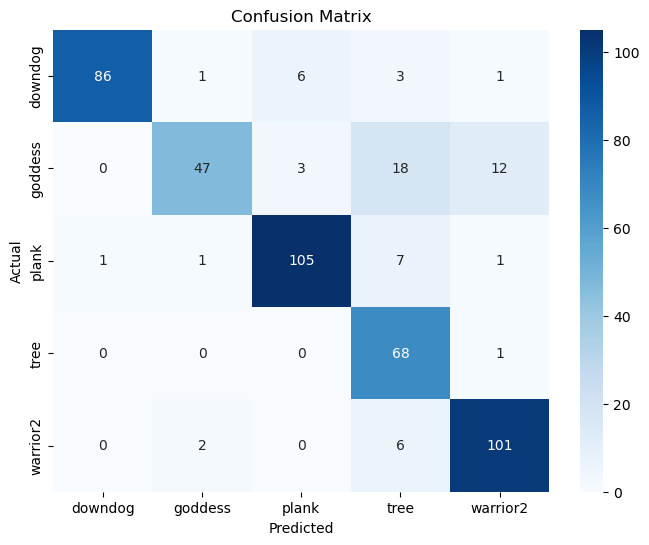

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
